## 1 Overview
An enviroment to train and evaluate neural networks on learning logical consequence. 

In [128]:
# For google collab
!git clone https://github.com/stereifberger/master-s-thesis
%cd master-s-thesis/

Cloning into 'master-s-thesis'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 245 (delta 127), reused 173 (delta 69), pack-reused 0
Receiving objects: 100% (245/245), 553.38 KiB | 7.09 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/home/str/master-s-thesis/master-s-thesis


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%cd master-s-thesis/

/home/str/master-s-thesis


/home/str/environments/general/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [130]:
# Install required dependencies - not necessary on google colab
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
# Import required libraries
from imports import *

In [132]:
importlib.reload(losses)

ModuleNotFoundError: spec not found for the module 'losses'

## 2 Create dataset
First the dataset for training is generated. For this the function "create_dataset" from "generation.py" utilizes the functions "gen_outp_PA" to generate a set of random starting formulas, for which iterativly the applicability of rules is checked. All applicable rules are then used to generate new derivations. In each iteration of gen_oupt_PA, set by the iterations variable, new, longer examples are generated.

**Rules.** The rules are defined in calculi.py. Two sets are avaiable: Intuitionistic propositional logic (set below via "calculus = ipl") and classical propositional logic (set below via "calculus = cpl").

**Dataset entries.**
- **x_train.** Training input: [INDEX, PREMISES, DERIVATION SYMBOL, CONCLUSION]
- **y_train_ordered.** Dataset of correct derivations where each sublist i correspnds to INDEX: [DERIVATIONS_0...DERIVATION_N]

**Encoding.** Propositional variables and logical constants are encoded as integers. The integers are then one-hot-encoded into unique sequences containing only 0s and ones with the length of the maximum integer value, the feature length. The shape of the individual entries is 2D: [SEQUENCE LENGTH, FEATURE LENGTH].

**Example entries withouth numerical representation and one-hot-encoding.**
- **x_train.** [2345, A, A THEN B, DERIVES, B OR C]
- **y_train_ordered.** Sublist 2345 is entry entry: [[A, A THEN B, B, B OR C], [A, A THEN B, B, A AND B, B OR C]]


In [1]:
importlib.reload(generation)

NameError: name 'importlib' is not defined

In [5]:
# Create dataset
x_train_2d, x_train_3d, y_train_ordered, max_y_train_len = generation.create_dataset(iterations = [1,2], calculus = calculi.ipl)

Processed at iteration 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Processed at iteration 2:   0%|          | 0/11427 [00:00<?, ?it/s]

Processed premises for sample conclusions at iteration 2:   0%|          | 0/13600 [00:00<?, ?it/s]

Checked derivations for sample conclusions:   0%|          | 0/163864 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/106692 [00:00<?, ?it/s]

  0%|          | 0/106692 [00:00<?, ?it/s]

Processed entries for x_train and y_tdict:   0%|          | 0/106692 [00:00<?, ?it/s]

Padded y_train_ordered:   0%|          | 0/52135 [00:00<?, ?it/s]

Padded x_train entries:   0%|          | 0/52135 [00:00<?, ?it/s]

LENINPT: 52135
LENy_t: 52135
Number x_train examples: 52135
Average number ground truth examples/x_train example: 2.0464563153351873


## 3 Prepare dataset and define model for training
Next with pytorch's dataloader the single training entries in x_train are assigned to batches of size "batch size" in mixed order. Then the different models are defined using definitions from "architectures.py". These models are:

- Feedforward network (net)
- Recurrent neural network (RNNNet)
- Long-short-term memory (LSTMNet)
- Transformers (TransformerModel)

In [6]:
# Use when gpu is present to empty its catch and define it as "device" for referencing it
torch.cuda.empty_cache()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Get the datasets' shapes for th model definitions later
two_d_shape = x_train_2d.shape
three_d_shape = x_train_3d.shape

In [8]:
x = torch.argmax(x_train_3d, dim=2) 
x[:, 0] = x_train_2d[:, 0]
x_train_3d = x

In [ ]:
#y = y_train_ordered
#y = y.reshape(len(y),len(y[0]),int(len(y[0][0])/14), 14)
#y = torch.argmax(y, axis=3) 
#y_train_3d = y

In [9]:
# Set train-test split to 80-20 and get the 2d dataset's shapes # [^1]
train_size = int(0.8 * len(x_train_2d)) 
test_size = len(x_train_2d) - train_size 
x_train_2d, x_test_2d = random_split(x_train_2d, [train_size, test_size])
train_size = int(0.8 * len(x_train_3d))
test_size = len(x_train_3d) - train_size
x_train_3d, x_test_3d = random_split(x_train_3d, [train_size, test_size])

In [10]:
max_y_length = int(max_y_train_len/14)

In [11]:
# Collect and mix the data in [^2]
train_dataloader_2d = DataLoader(dataset = x_train_2d, shuffle = True, batch_size = 50)
test_dataloader_2d = DataLoader(dataset = x_test_2d, shuffle = True, batch_size = 50)
train_dataloader_3d = DataLoader(dataset = x_train_3d, shuffle = True, batch_size = 50)
test_dataloader_3d = DataLoader(dataset = x_test_3d, shuffle = True, batch_size = 50)

In [11]:
# Define the four models [^3]
ffn_model = architectures.ffn(input_size = two_d_shape[1]-1, 
                              hidden_size = 10,
                              output_size = max_y_train_len,
                              dropout_rate = 0.1,
                              input_size_in = 756)

rnn_model = architectures.SimpleRNN(input_size = three_d_shape[2],
                              hidden_size = 120,
                              output_size = three_d_shape[2])
lst_model = architectures.lst(input_size = three_d_shape[2],
                              hidden_size = 20,
                              output_size = max_y_train_len)
tra_model = architectures.tra(input_size = three_d_shape[2],
                              hidden_size = 20,
                              output_size = max_y_train_len,
                              num_layers = 10,
                              nhead = 4)

/home/str/environments/general/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## FFN

In [12]:
y_train = y_train_ordered
print(y_train.shape)

torch.Size([52135, 11, 1008])


In [51]:
importlib.reload(architectures)

<module 'architectures' from '/home/str/master-s-thesis/architectures.py'>

In [52]:
encoder_ffn = architectures.Encoder_FFN(55, 100).to(device)
decoder_ffn = architectures.Decoder_FFN(14, 100).to(device)
ffn_model = architectures.Seq2Seq(encoder_ffn, decoder_ffn, device).to(device)

# Define the optimizer and loss function
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [53]:
def train_model(model, dataloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for i, x_train in enumerate(dataloader):
            x_train = x_train.to(device)
            optimizer.zero_grad()  #  <-- FOR PYTORCH
            #x_train = x_train.float()
            #print(x_train.shape)
            #print(x_train)

            y_pred = model(x_train[:,1:], max_y_length)               # Get the model's output for batch
            #print(f"PRED: {y_pred.shape}")
            loss = losses.nffn_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
            # ---------------------------------------------

            loss.backward()  #  <-- FOR PYTORCH
            optimizer.step() #  <-- FOR PYTORCH

            epoch_loss += loss.item()
        print(f'Epoch: {epoch+1:02}, Loss: {epoch_loss / len(dataloader):.4f}')

In [54]:
encoder_ffn = architectures.Encoder_FFN(55, 100).to(device)
decoder_ffn = architectures.Decoder_FFN((max_y_length*14), 100).to(device)
ffn_model = architectures.Seq2Seq(encoder_ffn, decoder_ffn, device).to(device)

# Define the optimizer and loss function
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [55]:
train_model(ffn_model, train_dataloader_3d, ffn_optimizer, criterion, 50)
torch.save(model.state_dict(), 'addition_model.pth')

Epoch: 01, Loss: 368.4035
Epoch: 02, Loss: 344.6034
Epoch: 03, Loss: 342.6792
Epoch: 04, Loss: 340.8866
Epoch: 05, Loss: 340.4205
Epoch: 06, Loss: 340.1344
Epoch: 07, Loss: 339.8989
Epoch: 08, Loss: 339.4429
Epoch: 09, Loss: 338.4736
Epoch: 10, Loss: 337.6013
Epoch: 11, Loss: 336.7221
Epoch: 12, Loss: 336.0811
Epoch: 13, Loss: 335.7389
Epoch: 14, Loss: 335.1871
Epoch: 15, Loss: 334.8815
Epoch: 16, Loss: 334.5682


KeyboardInterrupt: 

In [60]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = ffn_model(x_test[:,1:], max_y_length)               # Get the model's output for batch
        #y_pred = y_pred.squeeze()
        print(f"1:{x_test.shape}")
        print(f"1:{y_pred.shape}")
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            print(pred.shape)

            #test = x_test[index][1:].reshape(-1, 14)
            #pred = Tensor.cpu(pred)
            #test = Tensor.cpu(test)
            test = x_test[index][1:]
            #pred = y_pred[index]
            #print(f"2:{pred.shape}")
            #print(test)
            #test = torch.argmax(test, dim=1) 
            pred = torch.argmax(pred, dim=1) 
            #print(pred)

            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            #for k in test:
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

1:torch.Size([50, 53])
1:torch.Size([50, 966])
torch.Size([69, 14])
INPUT: ((q→(q∧p))p)⊢((q→(q∧p))∧p)
OUTPUT: ((→→)∧pq)p(pq)((pp))p)
torch.Size([69, 14])
INPUT: ((¬s)(p→s))⊢((p→s)∨q)
OUTPUT: ((→())(s)(((∨s)()))
torch.Size([69, 14])
INPUT: ((s∨(¬p))(s∧(s∧t)))⊢(t∨(s∧(s∧t)))
OUTPUT: ((s(((s)))(((s(()((sss))))))
torch.Size([69, 14])
INPUT: (pt)⊢((t∨p)∨r)
OUTPUT: (p(p)p((∨∨)(∨∨)
torch.Size([69, 14])
INPUT: ((t∧q)p)⊢(r∨p)
OUTPUT: (((p)p((∨∨)))
torch.Size([69, 14])
INPUT: (ps)⊢(p∧s)
OUTPUT: (((p∨)((∨)
torch.Size([69, 14])
INPUT: ((r∧t)p)⊢(p→r)
OUTPUT: (((p)p)(r∧())
torch.Size([69, 14])
INPUT: ((t∧q)p)⊢((t∧q)∧t)
OUTPUT: ((∧t)p)()∧()∧)
torch.Size([69, 14])
INPUT: ((q∨(r→q))t)⊢(t∨q)
OUTPUT: (((r))((∨)((∨))()
torch.Size([69, 14])
INPUT: (s(q∨t))⊢(p∨(r∨s))
OUTPUT: ((∨∨))(p∨∨)(∨∨)(∨∨))
torch.Size([69, 14])
INPUT: ((q→(q∧p))(q∨q))⊢((q→(q∧p))∨s)
OUTPUT: (qq→qqqq)qqqqq((qqqqqq))q
torch.Size([69, 14])
INPUT: (p(q∨(¬s)))⊢(p∧(p∨s))
OUTPUT: ((p()(())(((∨((())))
torch.Size([69, 14])
INPUT: (p(r∧t))⊢((r∧t)→

## RNN Encoder-Decoder

In [61]:
encoder_rnn = architectures.Encoder_RNN(55, 150, 150, 1).to(device)
decoder_rnn = architectures.Decoder_RNN(14, 150, 150, 6).to(device)
rnn_model = architectures.Seq2Seq(encoder_rnn, decoder_rnn, device).to(device)

# Define the optimizer and loss function
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
# Load the ground truth data to the gpu
y_train = y_train_ordered.to(device)
y_train_3d = y_train.view(int(len(y_train)), int(len(y_train[0])), int(len(y_train[0][0])/14), 14)

In [68]:
y_train_3d.shape[1]

10

In [70]:
# Training Loop
train_model(rnn_model, train_dataloader_3d, rnn_optimizer, criterion, 200)
torch.save(rnn_model.state_dict(), 'addition_model.pth')

Epoch: 01, Loss: 1.3078
Epoch: 02, Loss: 1.1981


KeyboardInterrupt: 

In [72]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = rnn_model(x_test[:,1:], max_y_length)               # Get the model's output for batch
        print(f"1:{x_test.shape}")
        print(f"1:{y_pred.shape}")
        index = 0
        while index < len(y_pred):
            test = x_test[index][1:]
            pred = y_pred[index]
            print(f"2:{test.shape}")
            pred = torch.argmax(pred, dim=1) 
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

1:torch.Size([50, 53])
1:torch.Size([50, 69, 14])
2:torch.Size([52])
INPUT: (r(s∧(q→s)))⊢(r∨r)
OUTPUT: (
2:torch.Size([52])
INPUT: ((t∧q)p)⊢((t∧q)∧t)
OUTPUT: (
2:torch.Size([52])
INPUT: ((s→(p→r))(s→s))⊢(r∨(s→s))
OUTPUT: (
2:torch.Size([52])
INPUT: (r(s∧(q→s)))⊢(r→s)
OUTPUT: (
2:torch.Size([52])
INPUT: (ps)⊢(p∨s)
OUTPUT: (
2:torch.Size([52])
INPUT: ((t→(p∨t))s)⊢(p∨s)
OUTPUT: (
2:torch.Size([52])
INPUT: ((q∨t)p)⊢(p∨p)
OUTPUT: (
2:torch.Size([52])
INPUT: ((r∧t)(t→s))⊢((r∧t)→r)
OUTPUT: (
2:torch.Size([52])
INPUT: (r(s∨t))⊢(p∨r)
OUTPUT: (
2:torch.Size([52])
INPUT: (r(¬p))⊢((¬p)∧(r∨(¬p)))
OUTPUT: (
2:torch.Size([52])
INPUT: ((q∧q)s)⊢(s∧q)
OUTPUT: (
2:torch.Size([52])
INPUT: ((q→p)q)⊢(t∨(q→p))
OUTPUT: (
2:torch.Size([52])
INPUT: (((s∧s)→r)s)⊢(p∨s)
OUTPUT: (
2:torch.Size([52])
INPUT: ((p→t)((r→q)∨r))⊢(r∨(p→t))
OUTPUT: (
2:torch.Size([52])
INPUT: (sp)⊢(s∨t)
OUTPUT: (
2:torch.Size([52])
INPUT: ((s∧r)t)⊢(t∧s)
OUTPUT: (
2:torch.Size([52])
INPUT: ((¬t)((p→q)→p))⊢(¬t)
OUTPUT: (
2:torch.Size([52])
I

## LSTM Encoder-Decoder

In [153]:
del lstm_model

# Manually invoke garbage collector
import gc
gc.collect()

NameError: name 'lstm_model' is not defined

In [154]:
encoder_lstm = architectures.Encoder_LSTM(55, 150, 150, 1).to(device)
decoder_lstm = architectures.Decoder_LSTM(14, 150, 150, 6).to(device)
lstm_model = architectures.Seq2Seq(encoder_lstm, decoder_lstm, device).to(device)

# Define the optimizer and loss function
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [155]:
# Load the ground truth data to the gpu
y_train = y_train_ordered.to(device)
y_train_3d = y_train.view(int(len(y_train)), int(len(y_train[0])), int(len(y_train[0][0])/14), 14)

In [156]:
importlib.reload(losses)

<module 'losses' from '/home/str/master-s-thesis/losses.py'>

In [16]:
def train_model(model, dataloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for i, x_train in enumerate(dataloader):
            x_train = x_train.to(device)
            optimizer.zero_grad()  #  <-- FOR PYTORCH
            #x_train = x_train.float()
            #print(x_train.shape)

            y_pred = model(x_train[:,1:], max_y_length)               # Get the model's output for batch
            #print(f"PRED: {y_pred.shape}")
            loss = losses.new_threed_mse_min_dist(y_pred, x_train, y_train_3d, max_y_length) # Calculate loss
            # ---------------------------------------------

            loss.backward()  #  <-- FOR PYTORCH
            optimizer.step() #  <-- FOR PYTORCH

            epoch_loss += loss.item()
        print(f'Epoch: {epoch+1:02}, Loss: {epoch_loss / len(dataloader):.4f}')

In [17]:
# Training Loop
train_model(lstm_model, train_dataloader_3d, lstm_optimizer, criterion, 200)
torch.save(lstm_model.state_dict(), 'addition_model.pth')

NameError: name 'lstm_model' is not defined

In [19]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = model(x_test[:,1:], max_y_length)               # Get the model's output for batch
        #y_pred = y_pred.squeeze()
        print(f"1:{x_test.shape}")
        print(f"1:{y_pred.shape}")
        index = 0
        while index < len(y_pred):
            #pred = y_pred[index].reshape(-1, 14)
            #test = x_test[index][1:].reshape(-1, 14)
            #pred = Tensor.cpu(pred)
            #test = Tensor.cpu(test)
            test = x_test[index][1:]
            pred = y_pred[index]
            print(f"2:{test.shape}")
            #print(f"2:{pred.shape}")
            #print(test)
            #test = torch.argmax(test, dim=1) 
            pred = torch.argmax(pred, dim=1) 
            #print(pred)

            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            #for k in test:
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

1:torch.Size([50, 55])
1:torch.Size([50, 72, 14])
2:torch.Size([54])
INPUT: (t(q∧r))⊢(t∨p)
OUTPUT: t(q∧r)((∨∨p)
2:torch.Size([54])
INPUT: (((t∧q)∧r)(s→r))⊢((s→r)∨p)
OUTPUT: ((t∧q)∧r)(s→r)(((→r)∨p)))∨)
2:torch.Size([54])
INPUT: ((t∨t)q)⊢(s∨q)
OUTPUT: (t∨t)q((t∨t)∧q)(s∨q)
2:torch.Size([54])
INPUT: ((p∧t)(¬q))⊢p
OUTPUT: (p∧t)(¬r)p
2:torch.Size([54])
INPUT: ((¬r)(p∧p))⊢((¬r)∨r)
OUTPUT: (¬r)(p∧p)((¬r)∨r)
2:torch.Size([54])
INPUT: ((p→s)r)⊢(s∨(p→s))
OUTPUT: (p→s)r((p→p)∧s)(p∨(p→s))
2:torch.Size([54])
INPUT: (q(s∧t))⊢((s∧t)→t)
OUTPUT: q(s∧t)t((s∧t)→t)
2:torch.Size([54])
INPUT: ((s∧r)(¬s))⊢((¬s)∧r)
OUTPUT: (s∧r)(¬s)r((¬s)∧r)
2:torch.Size([54])
INPUT: (t(p→q))⊢(q∨t)
OUTPUT: t(p→q)(q∨t)(q∨t)
2:torch.Size([54])
INPUT: (q(¬s))⊢((q∨p)∨r)
OUTPUT: q(¬s)(t∨p)((t∨s)∨s)
2:torch.Size([54])
INPUT: (((r∨t)→q)s)⊢(((r∨t)→q)∨q)
OUTPUT: ((r∨t)→s)p(((r∨t)→q)∨r)(((t∨t)∧)∨t)
2:torch.Size([54])
INPUT: (p(s∨q))⊢(q∨p)
OUTPUT: p(s∨q)(q∨(s∨q))(q∨p)
2:torch.Size([54])
INPUT: (s((s∨q)∧r))⊢((s∨q)∨s)
OUTPUT: s((s∨q)∧r)(s∨

## Transformer

In [150]:
importlib.reload(architectures)

<module 'architectures' from '/home/str/master-s-thesis/architectures.py'>

In [19]:
encoder_tra = architectures.TransformerEncoder(52, 150, 5, 150, 1).to(device)
decoder_tra = architectures.TransformerDecoder(14, 150, 1, 150, 3).to(device)
tra_model = architectures.Seq2SeqTransformer(encoder_tra, decoder_tra, device).to(device)


# Define the optimizer and loss function
tra_optimizer = optim.Adam(tra_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
train_model(tra_model, train_dataloader_3d, tra_optimizer, criterion, 50)
torch.save(tra_model.state_dict(), 'addition_model.pth')

Epoch: 01, Loss: 0.7050
Epoch: 02, Loss: 0.3789
Epoch: 03, Loss: 0.3141
Epoch: 04, Loss: 0.2772
Epoch: 05, Loss: 0.2525
Epoch: 06, Loss: 0.2348
Epoch: 07, Loss: 0.2217
Epoch: 08, Loss: 0.2109
Epoch: 09, Loss: 0.2024
Epoch: 10, Loss: 0.1965
Epoch: 11, Loss: 0.1916
Epoch: 12, Loss: 0.1874
Epoch: 13, Loss: 0.1836
Epoch: 14, Loss: 0.1784
Epoch: 15, Loss: 0.1748
Epoch: 16, Loss: 0.1732
Epoch: 17, Loss: 0.1722
Epoch: 18, Loss: 0.1688
Epoch: 19, Loss: 0.1670
Epoch: 20, Loss: 0.1657
Epoch: 21, Loss: 0.1649
Epoch: 22, Loss: 0.1624
Epoch: 23, Loss: 0.1611
Epoch: 24, Loss: 0.1618
Epoch: 25, Loss: 0.1600
Epoch: 26, Loss: 0.1590
Epoch: 27, Loss: 0.1580
Epoch: 28, Loss: 0.1570
Epoch: 29, Loss: 0.1557
Epoch: 30, Loss: 0.1554
Epoch: 31, Loss: 0.1548
Epoch: 32, Loss: 0.1544
Epoch: 33, Loss: 0.1529
Epoch: 34, Loss: 0.1535
Epoch: 35, Loss: 0.1522
Epoch: 36, Loss: 0.1515
Epoch: 37, Loss: 0.1515
Epoch: 38, Loss: 0.1519
Epoch: 39, Loss: 0.1501
Epoch: 40, Loss: 0.1503
Epoch: 41, Loss: 0.1502
Epoch: 42, Loss:

In [21]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = tra_model(x_test[:,1:], max_y_length)               # Get the model's output for batch
        #y_pred = y_pred.squeeze()
        print(f"1:{x_test.shape}")
        print(f"1:{y_pred.shape}")
        index = 0
        while index < len(y_pred):
            #pred = y_pred[index].reshape(-1, 14)
            #test = x_test[index][1:].reshape(-1, 14)
            #pred = Tensor.cpu(pred)
            #test = Tensor.cpu(test)
            test = x_test[index][1:]
            pred = y_pred[index]
            print(f"2:{test.shape}")
            #print(f"2:{pred.shape}")
            #print(test)
            #test = torch.argmax(test, dim=1) 
            pred = torch.argmax(pred, dim=1) 
            #print(pred)

            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            #for k in test:
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

1:torch.Size([50, 55])
1:torch.Size([50, 72, 14])
2:torch.Size([54])
INPUT: ((t∧p)(¬t))⊢((t∧p)∨t)
OUTPUT: (t∧p)(¬t)((t∧p)∨))((t∧))∨))
2:torch.Size([54])
INPUT: (r(q∧t))⊢(r∧t)
OUTPUT: r(q∧t)trr∧t)
2:torch.Size([54])
INPUT: (r((p→r)∨p))⊢(s∨(r∨q))
OUTPUT: r((p→r)∨p)(r∨q)(s∨(r∨q))
2:torch.Size([54])
INPUT: ((t∧(t→t))p)⊢(p∧t)
OUTPUT: (t∧(t→t))pt(p∧t)
2:torch.Size([54])
INPUT: (p(s∨(s→r)))⊢(q∨p)
OUTPUT: p(s∨(s→r))(p∨(s∨(s→r)))(q∨p)
2:torch.Size([54])
INPUT: (s(p∧s))⊢(s∨s)
OUTPUT: s(p∧s)s(s∨s)
2:torch.Size([54])
INPUT: ((s→s)s)⊢((s→s)∨r)
OUTPUT: (s→s)s((s→s)→s)((s→s)∨r)
2:torch.Size([54])
INPUT: ((t∨t)(¬p))⊢((¬p)→(r∨(¬p)))
OUTPUT: (t∨t)(¬p)(r∨(¬p))((¬p)→(r∨(¬p)))
2:torch.Size([54])
INPUT: ((t∨(t∧t))(q∧p))⊢p
OUTPUT: (t∨(t∧t))(q∧p)p
2:torch.Size([54])
INPUT: (sr)⊢(r∨r)
OUTPUT: sr(r∨r)
2:torch.Size([54])
INPUT: (t(t→q))⊢((s∨(t→q))∨s)
OUTPUT: t(t→q)(s∨(t→q))((s∨(t→q))∨s)
2:torch.Size([54])
INPUT: ((¬r)q)⊢((r∨(¬r))∨s)
OUTPUT: (¬r)q(r∨(¬s))((r∨(¬r))∨s)
2:torch.Size([54])
INPUT: ((s∧p)(s∧t))⊢(s∨s)
O

KeyboardInterrupt: 

## 4 Training
Each subsequent cell trains one of the four models and calculates their mean squared error loss for the nearest correct derivation from the dataset to the derivation provided by the model. The logic for this is impolemented in the custom loss function "mse_min_dist" in losses.py.

In [113]:
max_y_length

72

## Feedforward Network

In [127]:
# Load the feedforward model to the gpu 
ffn_model.to(device)

ffn(
  (l1): Linear(in_features=756, out_features=10, bias=True)
  (l2): Linear(in_features=756, out_features=10, bias=True)
  (l3): Linear(in_features=756, out_features=10, bias=True)
  (l4): Linear(in_features=756, out_features=10, bias=True)
  (l5): Linear(in_features=756, out_features=10, bias=True)
  (l6): Linear(in_features=756, out_features=10, bias=True)
  (l7): Linear(in_features=756, out_features=10, bias=True)
  (l8): Linear(in_features=756, out_features=10, bias=True)
  (l9): Linear(in_features=756, out_features=10, bias=True)
  (relu): ReLU()
  (l10): Linear(in_features=10, out_features=1008, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [15]:
### FFN ### [^5]
ffn_costval_train = [] # Define the lists for the loss values
ffn_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    ffn_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_2d):   # Loop over all batches
        x_train = x_train.to(device)
        ffn_optimizer.zero_grad()
        y_pred = ffn_model(x_train[:,1:])               # Get the model's output for batch
        cost = losses.nffn_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
        # Backpropagation
        cost.backward()
        ffn_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_2d) # Calculate average loss
    ffn_costval_train.append(avg_train_loss)

    ffn_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0
    # Analog to above but without training a loop over all batches
    with torch.no_grad():
        for i, x_test in enumerate(test_dataloader_2d):
            x_test = x_test.to(device)
            y_pred = ffn_model(x_test[:, 1:])
            cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    ffn_costval_test.append(avg_train_loss)

    if j % 2 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

NameError: name 'epochs' is not defined

In [25]:
from torch import Tensor

In [129]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_2d):
        x_test = x_test.to(device)
        y_pred = ffn_model(x_test[:, 1:])
        decoded = []
        decoded_part = []
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

INPUT: (((¬s)∨t)(r→(¬s)))⊢(((¬s)∨t)∨p)
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((p→p)(t→t))⊢(p→p)
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: (q(q∧r))⊢((q∧r)∨s)
OUTPUT: ((∧→))(r∨()(∨))(∨∨))
INPUT: (pr)⊢(p∨(p→r))
OUTPUT: (t(r)()())
INPUT: ((p∧(q→t))((q→q)→q))⊢p
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((t→r)t)⊢(t∧(t∨t))
OUTPUT: ((t∨))(r∨()(s)((∨))
INPUT: ((s→t)(q→r))⊢(t∨(q→r))
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((r∧(t∧q))p)⊢((r∧(t∧q))→p)
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((p→q)s)⊢(s∨p)
OUTPUT: ((∧∧))((∨∨)))
INPUT: (s(r∧(q∧p)))⊢(p∨(p∨s))
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: (q((r→p)∧r))⊢(q→(t∨q))
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: (s(t∧t))⊢(s∧(t∨s))
OUTPUT: s(t∨))(r∨()(s)(t∨s))
INPUT: (r((s∧s)∨s))⊢(r∨s)
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((s∨p)s)⊢((s∨p)∨q)
OUTPUT: ((∧→))(s∨(((∨))(∨))
INPUT: ((t→p)(¬p))⊢(s∨(¬p))
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((s→p)((s∧q)→p))⊢(((s∧q)→p)∨r)
OUTPUT: ((∧()(()))((∨))((∨()
INPUT: ((s∨p)s)⊢(q∨s)
OUTPUT: ((∧∧))((∨∨))
INPUT: (s(q→q))⊢((s∨r)∨p)
OUTPUT: ((t→))(r∨()(s)((∨))

## Recurrent Neural Network

In [43]:
rnn_model.to(device)

SimpleRNN(
  (rnn): RNN(14, 120, num_layers=5, batch_first=True)
  (fc): Linear(in_features=120, out_features=14, bias=True)
)

In [11]:
from torch import nn

In [183]:
importlib.reload(architectures)

<module 'architectures' from '/home/str/master-s-thesis/architectures.py'>

In [58]:
def reverse(inpt):
    inpt = tensor.detach().numpy(inpt)
    inpt = np.argmax(inpt, axis=1) 
    inpt = [calculi.symb_reverse[num.item()] for num in inpt]
    inpt = ''.join(inpt)
    return inpt

In [12]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(14, 2000, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(2000, 2000, num_layers=3, batch_first=True)
    (fc_out): Linear(in_features=2000, out_features=14, bias=True)
  )
)

In [45]:
### RNN ###
rnn_costval_train = [] # Define the lists for the loss values
rnn_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.new_threed_mse_min_dist(y_pred, x_train, y_train_3d, max_y_length) # Calculate loss
        # Backpropagation
        
        #print("IN")
        #print(reverse(selected_pred))
        #print("EXP")
        #print(reverse(selected_y))
        model_optimizer.zero_grad()
        cost.backward()
        model_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    rnn_costval_train.append(avg_train_loss)

    model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = model(x_test[:, 1:])
            cost = losses.new_threed_mse_min_dist(y_pred, x_test, y_train_3d, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    rnn_costval_test.append(avg_train_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Train Loss - 2.193727621615259, Test Loss - 2.1892230640286985
Epoch 1: Train Loss - 2.170285462681713, Test Loss - 2.1878433512604754
Epoch 2: Train Loss - 2.1912096536876073, Test Loss - 2.2117581160172173
Epoch 3: Train Loss - 2.1819035863615777, Test Loss - 2.1705971049225847
Epoch 4: Train Loss - 2.1869323351344123, Test Loss - 2.1818646607191665
Epoch 5: Train Loss - 2.186932330574494, Test Loss - 2.1731265524159307
Epoch 6: Train Loss - 2.188666382773978, Test Loss - 2.175655994726264
Epoch 7: Train Loss - 2.1775684721482906, Test Loss - 2.1912926098574763


KeyboardInterrupt: 

In [39]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = model(x_test[:, 1:])
        y_pred = y_pred.squeeze()
        print(y_pred.shape)
        index = 0
        while index < len(y_pred):
            #pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            #pred = Tensor.cpu(pred)
            #test = Tensor.cpu(test)
            pred = torch.argmax(y_pred, axis=1) 
            test = torch.argmax(test, axis=1) 

            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1

torch.Size([54, 14])
INPUT: ((p∨s)(s∨t))⊢(s∨t)
OUTPUT: 
INPUT: (s(p∧q))⊢(s∨t)
OUTPUT: 
INPUT: (((¬t)∧t)q)⊢(t∨q)
OUTPUT: 
INPUT: ((t→(t→s))s)⊢(p∨s)
OUTPUT: 
INPUT: ((¬t)(p→t))⊢((p→t)∨q)
OUTPUT: 
INPUT: ((t→p)r)⊢(r∧(r∨q))
OUTPUT: 
INPUT: (((r→p)∧q)r)⊢(r∧(r→p))
OUTPUT: 
INPUT: (q(¬q))⊢(q∨p)
OUTPUT: 
INPUT: ((¬r)t)⊢(t∨(¬r))
OUTPUT: 
INPUT: ((t→r)t)⊢((t→r)∧t)
OUTPUT: 
INPUT: ((q∧r)p)⊢(p∨(q∧r))
OUTPUT: 
INPUT: (s(p∧q))⊢((s∨p)∨p)
OUTPUT: 
INPUT: ((q∨p)(p∨p))⊢(p∨p)
OUTPUT: 
INPUT: (s(t∧q))⊢((t∧q)→t)
OUTPUT: 
INPUT: ((p∧r)(¬t))⊢r
OUTPUT: 
INPUT: (t(r→q))⊢(t→(t∨s))
OUTPUT: 
INPUT: (p(r∧(s∧r)))⊢(t∨(s∧r))
OUTPUT: 
INPUT: ((r→s)s)⊢(r→s)
OUTPUT: 
INPUT: ((p∨s)(s∨t))⊢((s∨t)→(s∨(s∨t)))
OUTPUT: 
INPUT: (r(t∨(q∧p)))⊢(r∧(r∨r))
OUTPUT: 
INPUT: (r(r→q))⊢(((r→q)∨t)∨s)
OUTPUT: 
INPUT: ((q∨(q∧t))(q→p))⊢((q∨(q∧t))∨p)
OUTPUT: 
INPUT: ((s∧p)(q→t))⊢(q→t)
OUTPUT: 
INPUT: (r(t∨(q∧p)))⊢(q∨r)
OUTPUT: 
INPUT: ((p∧s)p)⊢((p∧s)∧p)
OUTPUT: 
INPUT: ((p∧(t→t))(t→q))⊢((t→q)∨t)
OUTPUT: 
INPUT: ((s∨s)(t∨p))⊢(s∨s)
OUTPUT: 
INPU

IndexError: index 50 is out of bounds for dimension 0 with size 50

In [170]:
lst_model.to(device)

lst(
  (lstm): LSTM(14, 20, num_layers=10, batch_first=True)
  (fc): Linear(in_features=20, out_features=1008, bias=True)
)

In [171]:
### LSTM ###
lst_costval_train = [] # Define the lists for the loss values
lst_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    lst_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = lst_model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.threed_mse_min_dist(y_pred, x_train, y_train, max_y_length) # Calculate loss
        # Backpropagation
        lst_optimizer.zero_grad()
        cost.backward()
        lst_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    lst_costval_train.append(avg_train_loss)

    lst_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = lst_model(x_test[:, 1:])
            cost = losses.threed_mse_min_dist(y_pred, x_test, y_train, max_y_length)
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    lst_costval_test.append(avg_train_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Padding length should be less than or equal to two times the input dimension but got padding length 4 and input of dimension 1

In [ ]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = lst_model(x_test[:, 1:])
        print(y_pred.shape)
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

torch.Size([50, 1008])
INPUT: (((t∧r)∨t)(r→t))⊢((r→t)∧(((t∧r)∨t)→(r→t)))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∨r)s)⊢(s∨(t∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (((¬t)∧s)((s∨p)∨t))⊢s
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (s(s→(r∧r)))⊢(p∨(s∨p))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((q→s)p)⊢(p∨q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(s→(q∨t)))⊢(q∨(r∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∧(s∧q))t)⊢(t∨s)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((¬p)q)⊢q
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((r∨q)q)⊢(r∨q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r((p→s)∨t))⊢(r∨p)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(t→(t∧q)))⊢(r∨t)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((q→q)(p∧q))⊢((q→q)∨s)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(¬p))⊢r
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (q(r→(q∧q)))⊢q
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (((t∧s)∧q)t)⊢(p∨(t∨q))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((t∨r)(q→p))⊢(t∨(t∨r))
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (r(p∨t))⊢((p∨t)∨r)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: (p(q∧s))⊢((q∧s)∧q)
OUTPUT: ((∨∧))((∨)((∨))(
INPUT: ((p∧(q→p))p)⊢(p→(s∨p))
OUTPUT: ((∨∧

ValueError: only one element tensors can be converted to Python scalars

In [172]:
tra_model.to(device)

tra(
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): Linear(in_features=14, out_features=20, bias=True)
  (decoder): Linear(in_features=20, out_features=1008, bias=True)
)

In [174]:
### Transformer ###
tra_costval_train = [] # Define the lists for the loss values
tra_costval_test = []
for j in tqdm(range(epochs), desc = "Epoch"): # Loop over all epochs
    tra_model.train() # Set to training mode (weights are adjusted)
    train_loss = 0
    for i, x_train in enumerate(train_dataloader_3d):   # Loop over all batches
        x_train = x_train.to(device)
        y_pred = tra_model(x_train[:,1:])               # Get the model's output for batch 
        cost = losses.threed_mse_min_dist(y_pred, x_train, y_train_3d, (max_y_train_len/14)) # Calculate loss
        # Backpropagation
        tra_optimizer.zero_grad()
        cost.backward()
        tra_optimizer.step()
        train_loss += cost.item() # Append loss to intermediary list for average loss calculation
    avg_train_loss = train_loss / len(train_dataloader_3d) # Calculate average loss
    tra_costval_train.append(avg_train_loss)

    tra_model.eval() # Set evaluation mode (weights are not adjusted)
    test_loss = 0 
    # Analog to above but without training a loop over all batches
    with torch.no_grad(): 
        for i, x_test in enumerate(test_dataloader_3d):
            x_test = x_test.to(device)
            y_pred = tra_model(x_test[:, 1:])
            cost = losses.threed_mse_min_dist(y_pred, x_test, y_train, (max_y_train_len/14))
            test_loss += cost.item()
    avg_test_loss = test_loss / len(test_dataloader_2d)
    tra_costval_test.append(avg_test_loss)

    if j % 1 == 0: # Get the loss every 10 epochs
        print(f"Epoch {j}: Train Loss - {avg_train_loss}, Test Loss - {avg_test_loss}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (14) must match the size of tensor b (1008) at non-singleton dimension 2

In [ ]:
# A sanity test for wheter the outputs look appropriate
with torch.no_grad():
    for i, x_test in enumerate(test_dataloader_3d):
        x_test = x_test.to(device)
        y_pred = tra_model(x_test[:, 1:])
        print(y_pred.shape)
        index = 0
        while index < len(y_pred):
            pred = y_pred[index].reshape(-1, 14)
            test = x_test[index][1:].reshape(-1, 14)
            pred = Tensor.cpu(pred)
            test = Tensor.cpu(test)
            pred = np.argmax(pred, axis=1) 
            test = np.argmax(test, axis=1) 
            #k = Tensor.cpu(k)
            #k = np.array(k)
            #k = (k == k.max(axis=1)[:,None]).astype(int) # https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
            #k = torch.argmax(k, dim=1)
            test = [calculi.symb_reverse[num.item()] for num in test]
            test = ''.join(test)
            pred = [calculi.symb_reverse[num.item()] for num in pred]
            pred = ''.join(pred)
            print(f"INPUT: {test}")
            print(f"OUTPUT: {pred}")
            index += 1
        cost = losses.nffn_mse_min_dist(y_pred, x_test, y_train, max_y_length)
        test_loss += cost.item()
avg_test_loss = test_loss / len(test_dataloader_2d)
ffn_costval_test.append(avg_train_loss)

torch.Size([50, 54, 1008])
INPUT: (q(r→(q∧q)))⊢q
OUTPUT: ((∧∧))(())((∨))(()))((∨∧))(())((∨()(((()((∧r)((())((∨)(((∨(())((sq)((())((∨()((t)))((r())(())((()((t)))((∧∧))(())(()))((∨))((→)))()))((p))(())((t())(())(q∨))(())))((∧∧)((())((∨(((())((→∧)((())((∨))((∨))((→∧)((())((∨))((()((→∧))(())((s()(()((r∧))(s))(()()((()((rq))(())((→()((t∨))((→q))(())((()((∨)))((∧∧))(())(((((((∨)((r())(())(())()∧))))((→∨))(())((∨))(()))(((q))(∧))((∨))(∧()))((→q))(())(()()(())((∧()((())((∨()((∨)))((∧())(())((∨))(()))((∧r))(())(()))((∨)))((∧∧))()))((∨))(()))(((r))(())((∨()(()))((∧∧))(())((∨))((()((q()((())((∨((((∨)))((→q))pt))(q∨))(∨)))((∧q)((())((s()((()((∧q))(())((p()(∨)((r∧))(())(()((((∨))((∨())(())((∨))(())))((∨∨))(())(()((((t))((∧()((())((∨()((∨))((∧∧))(())(()(((())((→∧)(()))((q()((())(((∧))(())()∨()((∨)))((→∧))(())(()()(()((→∧))(s))(()()(())(((())(())((∨))(()))((∧q))(())((∨)(((∨)))((→∧))(())((∨))((∨)((→∧))(())(()))(∨))((∧∧)((()((())(((∨()((→q))(())((p(((((((∨q))(())((∨()(()))((→∧)((())((∨))((∨())((→q))(()

ValueError: only one element tensors can be converted to Python scalars

## 5 Plot results
Here all results from above are plotted.

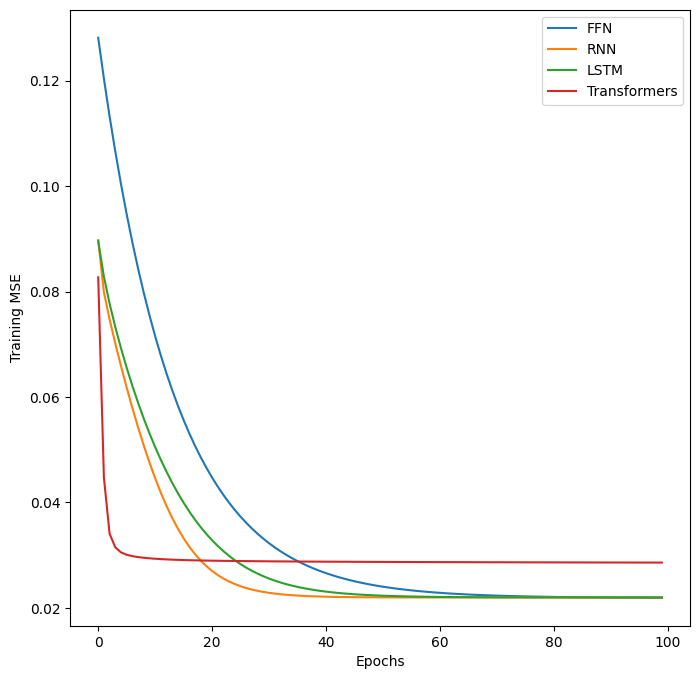

In [ ]:
plt.figure(figsize=(8, 8))
x_data = list(range(100))
y_data_ffn = ffn_costval_train
y_data_rnn = rnn_costval_train
y_data_lst = lst_costval_train
y_data_tra = tra_costval_train
plt.plot(x_data, y_data_ffn, label='FFN')
plt.plot(x_data, y_data_rnn, label='RNN')
plt.plot(x_data, y_data_lst, label='LSTM')
plt.plot(x_data, y_data_tra, label='Transformers')
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.legend()
plt.show()

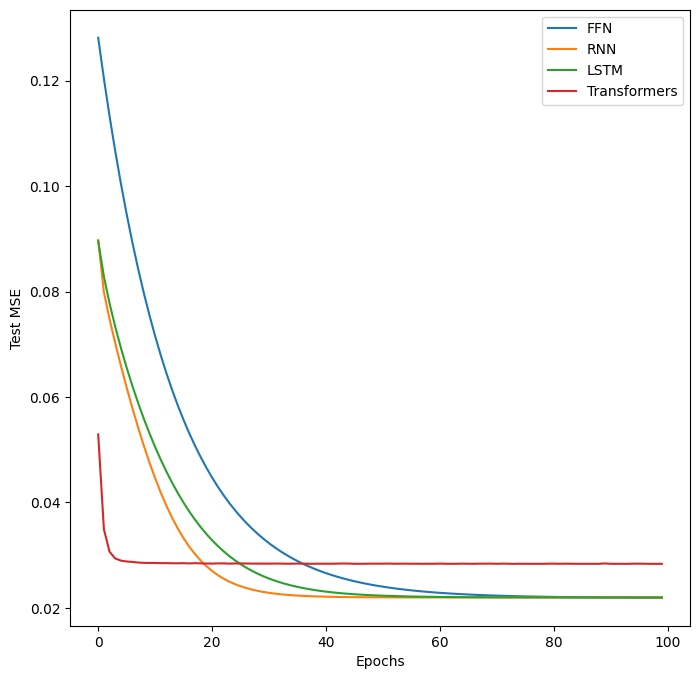

In [ ]:
plt.figure(figsize=(8, 8))
x_data = list(range(100))
y_data_ffn = ffn_costval_test
y_data_rnn = rnn_costval_test
y_data_lst = lst_costval_test
y_data_tra = tra_costval_test
plt.plot(x_data, y_data_ffn, label='FFN')
plt.plot(x_data, y_data_rnn, label='RNN')
plt.plot(x_data, y_data_lst, label='LSTM')
plt.plot(x_data, y_data_tra, label='Transformers')
plt.xlabel('Epochs')
plt.ylabel('Test MSE')
plt.legend()
plt.show()